### Modeling

By Kyra Jongman

### Inhoudsopgave

- Importeren packages
- Importeren data
- Modellering
- Voorbeeld tokenizer
- Evaluatie
    1. Evalueren aantal epochs
    2. Evalueren van het T5 model
        - 2.1 Data verdelen in vier verschillende soorten output
        - 2.2 Antwoorden van medewerker ('A') splitsen van lijst met 'PAN' en 'PAV' indicatoren 
        - 2.3 Berekenen van de similarity scores
        - 2.4 Berekenen van gemiddelde similarity scores per output
- Gesprek testen

### Importeren packages

In [1]:
import pickle
from simplet5 import SimpleT5
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer
from scipy.spatial import distance
import pandas as pd
import torch, gc
import seaborn as sns
import collections

Global seed set to 42


### Importeren data

In [2]:
with open("data.pickle", "rb") as input_file:
    data = pickle.load(input_file)

In [3]:
train_df, eval_df = train_test_split(data, test_size=0.2,random_state=23)
print(train_df.shape, eval_df.shape)

(24889, 2) (6223, 2)


### Modellering

De onderstaande code is met behulp van Google Colab Pro gerund. Python gaf namelijk een memory error.

In [4]:
# model = SimpleT5()
# model.from_pretrained(model_type="t5", model_name="t5-base")

# gc.collect()
# torch.cuda.empty_cache()

# model.train(train_df=train_df,
#             eval_df=eval_df, 
#             source_max_token_len=1024, 
#             target_max_token_len=256, 
#             batch_size=2, max_epochs=4)

### Voorbeeld tokenizer

De onderstaande code is gerund om na te gaan hoe de T5 tokenziner werkt. Gezien kan worden dat ieder woord gekoppeld wordt aan een getal. Deze getallen worden opgeslagen in een lijst die vervolgens verwerkt kan worden door het T5 model. 

In [13]:
from transformers import T5TokenizerFast as T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")
tokenizer('Hello, how can I help you?')['input_ids']

[8774, 6, 149, 54, 27, 199, 25, 58, 1]

### Evaluatie

#### 1. Evalueren aantal epochs

Om na te gaan of het model niet te veel traint en daardoor slechter gaat presenteren, zijn de training loss en de evaluatie loss tegenover elkaar geplot in een lijndiagram. Gezien kan worden dat zowel de training loss als de evaluatie loss dalen. De evaluatie loss daalt echter minder snel dan te training loss. Dit betekent dat het model na epoch 4 niet meer zoveel verbeterd en het aantal epochs dus niet verhoogd moet worden. 

In [4]:
#De training en evaluatie loss van de verschillende epochs
epochs = ["simplet5-epoch-0-train-loss-0.7651-val-loss-0.6165", 
"simplet5-epoch-1-train-loss-0.5994-val-loss-0.5789", 
"simplet5-epoch-2-train-loss-0.5289-val-loss-0.5577",
"simplet5-epoch-3-train-loss-0.477-val-loss-0.5494",
"simplet5-epoch-4-train-loss-0.4324-val-loss-0.5469"]

In [5]:
#De training en evaluatie loss transformeren naar een dataset
epoch_list = {'epoch_name' : [], 'epoch_train_loss' : [], 'epoch_val_loss' : []}
for epoch in epochs:
    epoch_list['epoch_name'].append(' '. join(epoch.split("-")[2:3]))
    epoch_list['epoch_train_loss'].append(float(' '. join(epoch.split("-")[5:6])))
    epoch_list['epoch_val_loss'].append(float(' '. join(epoch.split("-")[8:9])))
epoch_df = pd.DataFrame(epoch_list)

epoch_df_melt = epoch_df.melt('epoch_name', var_name='cols', value_name='vals')
epoch_df_melt

,epoch_name,cols,vals
0,0,epoch_train_loss,0.7651
1,1,epoch_train_loss,0.5994
2,2,epoch_train_loss,0.5289
3,3,epoch_train_loss,0.4770
4,4,epoch_train_loss,0.4324
5,0,epoch_val_loss,0.6165
6,1,epoch_val_loss,0.5789
7,2,epoch_val_loss,0.5577
8,3,epoch_val_loss,0.5494
9,4,epoch_val_loss,0.5469


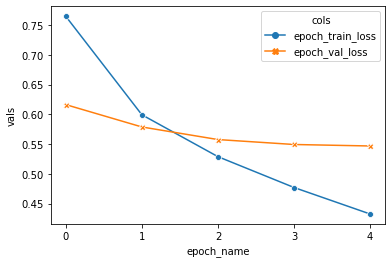

In [6]:
#Dataframe plotten in een lijndiagram
sns.lineplot(
    data=epoch_df_melt,
    x="epoch_name", y="vals", hue="cols", style="cols",
    markers=True, dashes=False
);

#### 2. Evalueren van het T5 model met het DistillBert model

Daarnaast is ook de ouput, voorspelde antwoord, van het T5 model geëvalueerd. Dit is gedaan door middel van het DistillBert model. Dit model berekend de gelijkenis tussen twee zinnen. Komt het 'echte' antwoord overheen met het voorspelde antwoord. 

In [10]:
#Het beste getrainde model importeren van Google Colab Pro
model = SimpleT5()
model.from_pretrained(model_type="t5", model_name="t5-base")
model.load_model("t5", 'outputs (datum 17-05)\content\outputs\simplet5-epoch-4-train-loss-0.4324-val-loss-0.5469')

In [47]:
#Antwoorden voorspellen op basis van de source text uit de evaluatie dataset
#total_prediction = [model.predict(row) for row in eval_df['source_text']]

In [14]:
#De voorspelde antwoorden opslaan in een pickle
# with open('total_prediction.pickle', 'wb') as handle:
#     pickle.dump(total_prediction, handle)

#Voorspelde antwoorden openen
with open('total_prediction.pickle', 'rb') as handle:
    total_prediction = pickle.load(handle)

In [15]:
#Extra kolom toevoegen aan de evaluatie dataset met de voorspelde antwoorden
prediction_df = eval_df.copy()
prediction_df['predicted_target_text'] = [" ".join(items) for items in total_prediction] 
prediction_df.head(5)

,source_text,target_text,predicted_target_text
11317,"question-answer: <U>probably you know, a four ...",<PAN>hotel_search.star_rating<PAV>a four star ...,PAN>hotel_search.star_ratingPAV>four star A>do...
12465,question-answer: <U>that sounds great. <PRAN>h...,<A>you have any questions about willows?,A>would you like to book your stay with the wi...
28291,question-answer: <U>i'm looking for a hotel ha...,"<PAN>hotel_search. num.beds<PAV>two <A>okay, y...",PAN>hotel_search. num.bedsPAV>two beds
17252,"question-answer: <U>oh yeah, it's got to have ...",<PAN>hotel_search. num.beds<PAV>two <A>what is...,PAN>hotel_search. num.bedsPAV>two beds
570,question-answer: <U>that's all my requirements...,<A>let me see what i can find. <A>hold on. <A>...,"A>okay, let me see what hotels i can find for ..."


##### 2.1 Data verdelen in vier verschillende soorten output

- Een 'gewoon' antwoord gebaseerd op de gesprekscontext
- Een 'gewoon' antwoord in combinatie met een indicator
- Een indicator als antwoord
- Een antwoord gebaseerd op resultaten van een indicator

In [7]:
#Lijst met antwoorden gebaseerd op de resultaten van een indicator
PR_rows = []
#Lijst waar de indicators nog gesplitst moeten worden van de 'gewone' antwoorden, zie 2.2
PAN_A_rows = []
#Lijst met indicators als antwoord
PAN_rows = []
#Lijst met 'gewone' antwoorden gebaseerd op de gesprekscontext
A_rows = []

for index, row in prediction_df.iterrows():
    if '<PR>' in row['source_text']:
        PR_rows.append(index)
    elif '<PAN>' in row['target_text']:  
        if '<A>' in row['target_text']:
            PAN_A_rows.append(index)
        else:
            PAN_rows.append(index)
    else:
        A_rows.append(index)

##### 2.2 Antwoorden van medewerker ('A') splitsen van lijst met 'PAN' en 'PAV' indicatoren

In [8]:
#Lijst waar de indicators nog gesplitst moeten worden van de 'gewone' antwoorden
def split_target(text: str) -> tuple:
    splitted_targets = []
    delimiters = []
    for char, index in zip(text, range(len(text))):
        if char == '>':
            delimiters.append(index)
    delimiters.append(None)
    
    for begin, end in zip(delimiters[::1],delimiters[1::1]):
        if not end:
            final_end = end
            if text[begin-1] == 'A':
                final_begin = begin-1
            elif text[begin-2:begin] == 'PN':
                final_begin = begin-2
            elif text[begin-2:begin] == 'AN':
                final_begin = begin-3
            elif text[begin-1] == 'V':
                final_begin = begin-3
        else:
            if text[begin-1] == 'A':
                final_begin = begin-1
            elif text[begin-2:begin] == 'PN':
                final_begin = begin-2
            elif text[begin-2:begin] == 'AN':
                final_begin = begin-3
            elif text[begin-1] == 'V':
                final_begin = begin-3
            
            if text[end-1] == 'A':
                if text[end-2] == '<':
                    final_end = end-2
                else:
                    final_end = end-1
            elif text[end-2:end] == 'PN':
                if text[end-3] == '<':
                    final_end = end-3
                else:
                    final_end = end-2
            elif text[end-2:end] == 'AN':
                if text[end-4] == '<':
                    final_end = end-4
                else:
                    final_end = end-3
            elif text[end-1:end] == 'V':
                if text[end-4] == '<':
                    final_end = end-4
                else:
                    final_end = end-3
                    
        splitted_targets.append(text[final_begin:final_end])
          
    pav_list = [string  for string in splitted_targets if 'A>' not in string]
    a_list = [string  for string in splitted_targets if 'A>' in string]
    if a_list:
        a_string = ' '.join([string  for string in splitted_targets if 'A>' in string])
    else:
        a_string = ''
    pav_string = ' '.join([string  for string in splitted_targets if 'A>' not in string])
    
    return(pav_string, a_string)

In [9]:
#Bovengenoemde functie gebruiken om indicators van 'gewone' antwoorden te splitten
PAN_A_target = [split_target(items) for items in prediction_df.loc[PAN_A_rows]['target_text']]
PAN_A_predicted_target = [split_target(items) for items in prediction_df.loc[PAN_A_rows]['predicted_target_text']]

In [10]:
#Dataframe maken voor de antwoorden die gesplitst zijn
PAN_A_target_df = pd.DataFrame(PAN_A_target)
PAN_A_target_df = PAN_A_target_df.rename(columns={0: "PAN_target", 1: "A_target"})

PAN_A_predictedtarget_df = pd.DataFrame(PAN_A_predicted_target)
PAN_A_predictedtarget_df = PAN_A_predictedtarget_df.rename(columns={0: "PAN_predicted_target", 1: "A_predicted_target"})

PAN_df = pd.concat([PAN_A_target_df['PAN_target'], PAN_A_predictedtarget_df['PAN_predicted_target']], axis=1)
PAN_df = PAN_df.rename(columns={"PAN_target": "target_text", "PAN_predicted_target": 'predicted_target_text'})
A_df = pd.concat([PAN_A_target_df['A_target'], PAN_A_predictedtarget_df['A_predicted_target']], axis=1)
A_df = A_df.rename(columns={"A_target": "target_text", "A_predicted_target": 'predicted_target_text'})

##### 2.3 Berekenen van de similarity scores

In [365]:
PAN_similarity = pd.concat([prediction_df.loc[PAN_rows][['target_text', 'predicted_target_text']], PAN_df])
PR_similarity = prediction_df.loc[PR_rows][['target_text', 'predicted_target_text']]

In [13]:
#De echte en voorspelde antwoorden worden opgeslagen in een pickle
#Met behulp van Google Colab Pro wordt vervolgens de similarity score berekend. Ook hier gaf Python namelijk een memory error.
with open('A_from_PAN.pickle', 'wb') as handle:
    pickle.dump(A_df, handle)
    
with open('A_not_from_PAN.pickle', 'wb') as handle:
    pickle.dump(prediction_df.loc[A_rows][['target_text', 'predicted_target_text']], handle) 
    
with open('PAN_similarity.pickle', 'wb') as handle:
    pickle.dump(PAN_similarity, handle)

with open('PR_similarity.pickle', 'wb') as handle:
    pickle.dump(PR_similarity, handle)

In [ ]:
#Similarity wordt berekend met behulp van onderstaande functie
def calculate_similarity(text):
    sentence_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    
    sentences = [text[0], text[1]]
    sentence_embeddings = sentence_model.encode(sentences) 
    similarity_score = 1 - distance.cosine(sentence_embeddings[0], sentence_embeddings[1])
    return similarity_score

In [7]:
#Openen van bestanden met de similarity scores
with open('PAN_PAV_similarity.pickle', 'rb') as handle:
    PAN_PAV_similarity = pickle.load(handle)
    
with open('A_from_PAN_similarity.pickle', 'rb') as handle:
    A_from_PAN_similarity = pickle.load(handle)
    
with open('A_not_from_PAN_similarity.pickle', 'rb') as handle:
    A_not_from_PAN_similarity = pickle.load(handle)
    
with open('PR_answer_similarity.pickle', 'rb') as handle:
    PR_answer_similarity = pickle.load(handle)

##### 2.4 Berekenen van gemiddelde similarity scores per output

In [2]:
#Functie om het gemiddelde te berekenen
def Average(lst):
    return sum(lst) / len(lst)

In [8]:
print("Gemiddelde similarity score van rijen met een indicator als antwoord: ", round(Average(PAN_PAV_similarity),2))
print("Gemiddelde similarity score van rijen met een 'gewoon' antwoord in combinatie met een indicator: ", round(Average(A_from_PAN_similarity),2))
print("Gemiddelde similarity score van rijen met een 'gewoon' antwoord gebaseerd op de geprekscontext: ", round(Average(A_not_from_PAN_similarity),2))
print("Gemiddelde similarity score van rijen met een antwoord gebaseerd op resultaten van een indicator: ", round(Average(PR_answer_similarity),2))

Gemiddelde similarity score van rijen met een indicator als antwoord:  0.9
Gemiddelde similarity score van rijen met een 'gewoon' antwoord in combinatie met een indicator:  0.63
Gemiddelde similarity score van rijen met een 'gewoon' antwoord gebaseerd op de geprekscontext:  0.74
Gemiddelde similarity score van rijen met een antwoord gebaseerd op resultaten van een indicator:  0.73


### Gesprek testen

In [33]:
class Conversation:

    def __init__(self):
        self.context = '<C>'
        self.annotation_list = []

    def user_sentence(self, user_sentence):
        user_sentence = "<U>" + user_sentence
        #Lijst met alle indicatoren wordt bijgehouden zodat de digital human deze aan het einde van de conversatie kan vertellen aan de klant
        if 'Okay' in user_sentence or 'Great' in user_sentence:
            a = []
            for i in self.annotation_list:
                #attribute names
                try:
                    a.append(i.split("PAV>")[0].split(".")[1] + " " + i.split("PAV>")[0].split(".")[2] + " is")
                except:
                    try: 
                        a.append(i.split("PAV>")[0].split(".")[1].split("_")[0] + " " + i.split("PAV>")[0].split(".")[1].split("_")[1] + " is")
                    except:
                        a.append(i.split("PAV>")[0].split(".")[1] + " is")
                #attribute values
                a.append(i.split("PAV>")[1])
            a.insert(0, "Finding a suitable hotel for the customer with the help of the following attributes:")
            test = ' '.join(a) 
            return test
        else:
            answer = model.predict(user_sentence + self.context)[0]
            if 'PAN>' in answer:
                if 'A>' not in answer:
                    answer += " A>" + answer.split("PAV>")[1] +'?'
                    self.annotation_list.extend([answer.split(" A>")[0]])
                else:
                    self.annotation_list.extend([answer.split(" A>")[0]])
            new_context = user_sentence + " " + "<" + answer
            self.context = self.context + " " + new_context
            return answer.split("A>")[1]

In [36]:
conv = Conversation()